Total Number of Samples: 454684
Unique Artworks: 80031
Average Caption Length: 15.69 words


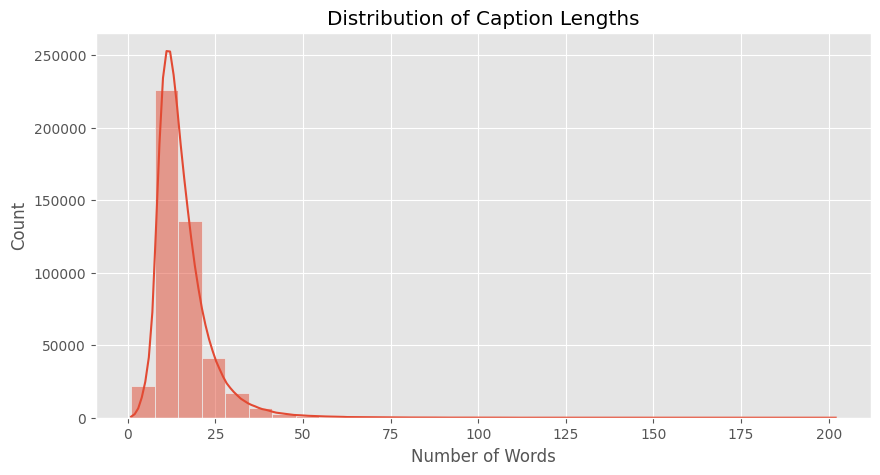

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.util import ngrams
import os
from PIL import Image

# Setup
# nltk.download('punkt') # Uncomment if not downloaded
plt.style.use('ggplot')

# Load the dataset
# Assuming columns: 'art_style', 'painting', 'emotion', 'utterance' (standard ArtEmis format)
# Adjust column names if your CSV is different.
df = pd.read_csv("captions.csv") 

# 1. Basic Counts
print(f"Total Number of Samples: {len(df)}")
print(f"Unique Artworks: {df['painting'].nunique()}")

# 2. Caption Length Analysis
df['caption_length'] = df['utterance'].apply(lambda x: len(str(x).split()))
avg_len = df['caption_length'].mean()
print(f"Average Caption Length: {avg_len:.2f} words")

# Plot Caption Length Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['caption_length'], bins=30, kde=True)
plt.title("Distribution of Caption Lengths")
plt.xlabel("Number of Words")
plt.show()

Vocabulary Size (unique words): 99870


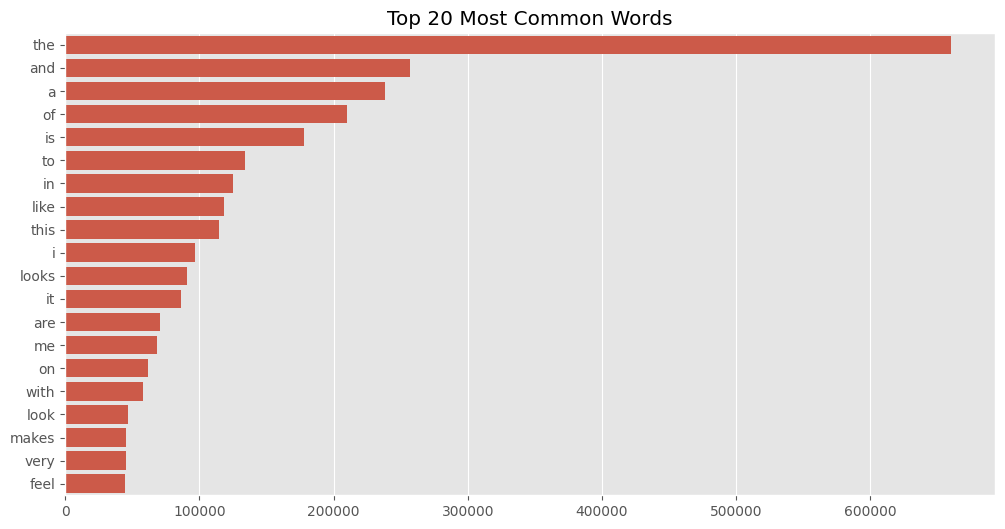

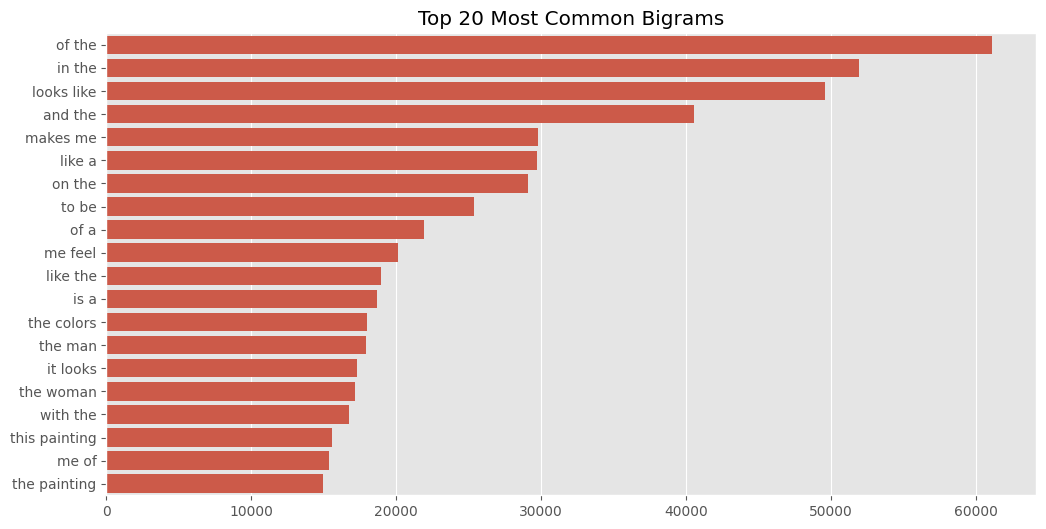

In [6]:
# Helper function to get top N-grams
def get_top_ngrams(corpus, n=1, top_k=20):
    vec = []
    for text in corpus:
        tokens = str(text).lower().split()
        # Create n-grams
        if len(tokens) >= n:
            vec.extend(list(ngrams(tokens, n)))
            
    # Count frequency
    counter = Counter(vec)
    return counter.most_common(top_k)

# 1. Vocabulary Size
all_words = [word for caption in df['utterance'] for word in str(caption).lower().split()]
vocab_size = len(set(all_words))
print(f"Vocabulary Size (unique words): {vocab_size}")

# 2. Top 20 Words (Unigrams)
top_words = get_top_ngrams(df['utterance'], n=1, top_k=20)
words, counts = zip(*top_words)
words = [w[0] for w in words] # Extract word from tuple

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title("Top 20 Most Common Words")
plt.show()

# 3. Top 20 Bigrams (Two-word combinations)
top_bigrams = get_top_ngrams(df['utterance'], n=2, top_k=20)
bigrams, counts = zip(*top_bigrams)
bigrams = [" ".join(b) for b in bigrams]

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(bigrams))
plt.title("Top 20 Most Common Bigrams")
plt.show()

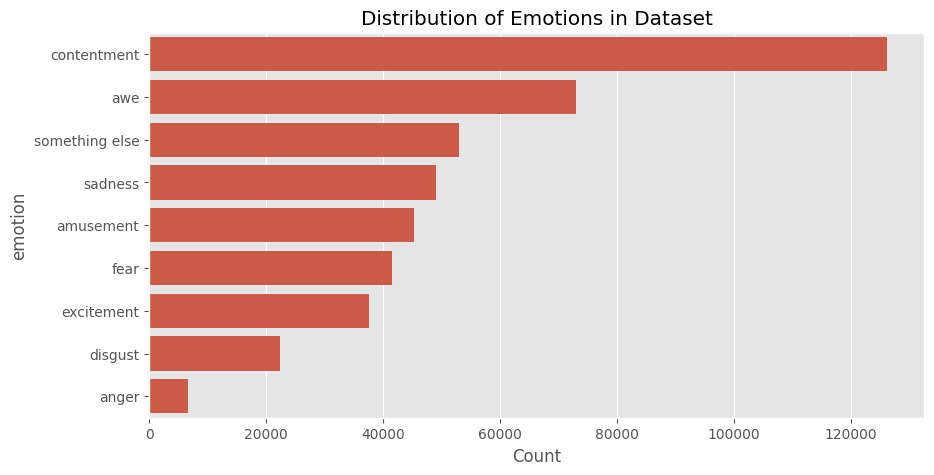

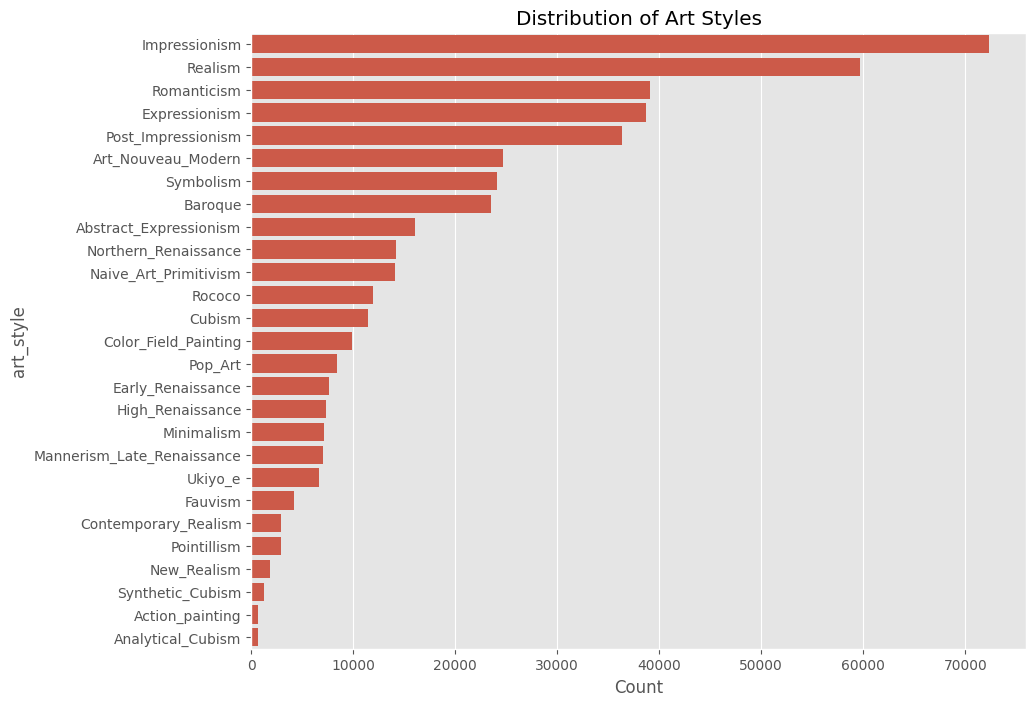

In [7]:
# 1. Emotion Distribution
plt.figure(figsize=(10, 5))
sns.countplot(y='emotion', data=df, order=df['emotion'].value_counts().index)
plt.title("Distribution of Emotions in Dataset")
plt.xlabel("Count")
plt.show()

# 2. Art Style Distribution
# This checks if your subset is biased towards one style (e.g., Impressionism)
plt.figure(figsize=(10, 8))
sns.countplot(y='art_style', data=df, order=df['art_style'].value_counts().index)
plt.title("Distribution of Art Styles")
plt.xlabel("Count")
plt.show()


Sample 1: The leaves are turning colors in the Autumn
Sample 2: The sky is a perfect blue, the home a bright cheery yellow. The flowering trees anticipate generous bounty of fruit, creating the beginning of a perfect summer season harvest to come.
Sample 3: The female looks like she wants to show off the back of her hair


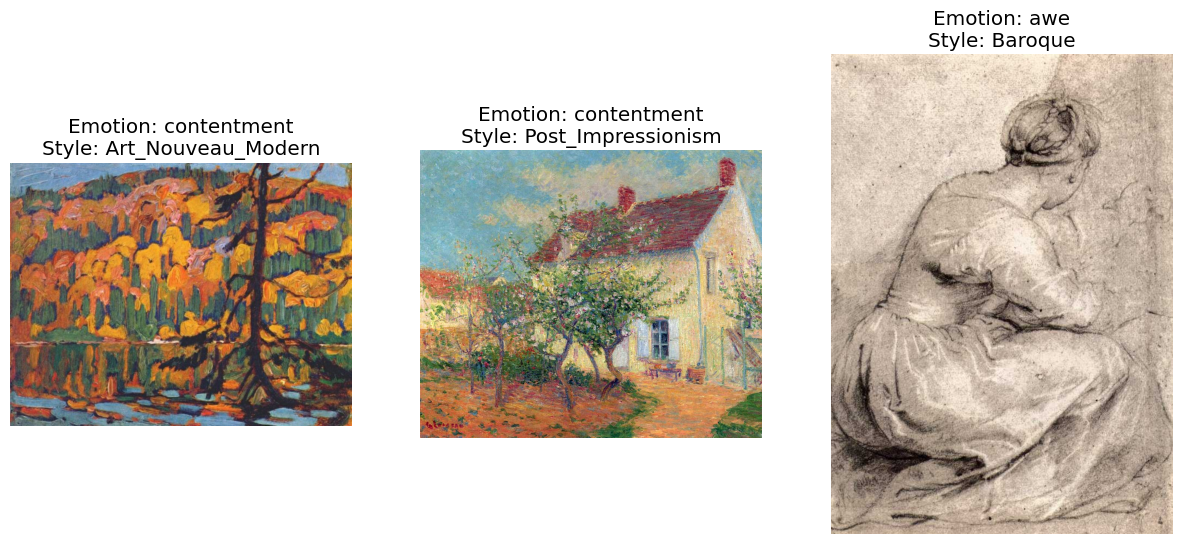

In [8]:
import random

def visualize_samples(df, image_folder, num_samples=3):
    plt.figure(figsize=(15, 10))
    
    # Sample random rows
    samples = df.sample(num_samples)
    
    for i, (_, row) in enumerate(samples.iterrows()):
        img_name = row['painting'] # Or 'image_file' depending on your CSV
        caption = row['utterance']
        emotion = row['emotion']
        style = row['art_style']
        
        # Load image
        img_path = os.path.join(image_folder, style, img_name + ".jpg") 
        # Note: ArtEmis folder structure is usually style/painting.jpg. 
        # Adjust path logic if your images are all in one folder.
        
        try:
            image = Image.open(img_path)
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(image)
            plt.title(f"Emotion: {emotion}\nStyle: {style}")
            plt.axis("off")
            
            # Print caption below
            print(f"Sample {i+1}: {caption}")
        except FileNotFoundError:
            print(f"Could not find image: {img_path}")

    plt.show()

# Run visualization
# Replace "wikiart/" with the actual path to your images folder
visualize_samples(df, image_folder="wikiart/", num_samples=3)

# 3. Preprocessing

Initializing Vocabulary and DataLoader...
✅ Preprocessing Complete.
Vocabulary Size: 17569 words
Number of Batches: 14209


/Users/ape/Documents/Ashoka/Monsoon 2025/Introduction to Machine Learning/Assignments/Assignment 3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Batch Verification ---
Image Batch Shape: torch.Size([32, 3, 224, 224])
Caption Batch Shape: torch.Size([32, 47])


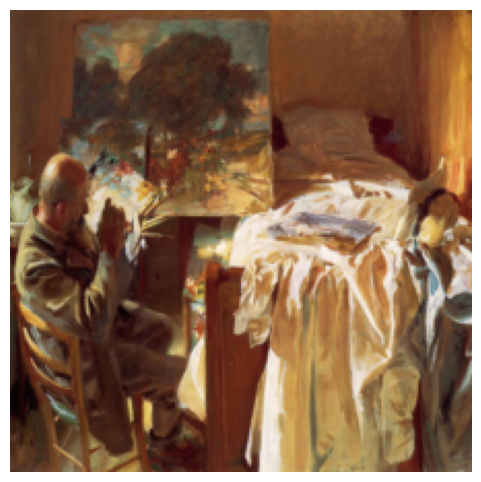

Ground Truth Caption (Decoded): the fabric sheets he using to display his paintings is so beautiful


In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
# Import the custom classes we defined in preprocessing.py
# If you didn't create the file, paste the classes in a cell above this one.
from preprocessing import get_loader 

# --- 1. Configuration & Constants ---
# Assignment requires resizing to fixed shape (e.g., 224x224) 
# ToTensor() automatically converts images to [0, 1] range 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
])

# Define your paths (Update these to match your local setup)
IMAGE_FOLDER = "./wikiart/"   # Folder containing the style subfolders
CAPTIONS_FILE = "captions.csv" # Your subset or full csv path
BATCH_SIZE = 32

# --- 2. Initialize Data Loaders ---
print("Initializing Vocabulary and DataLoader...")
# This will build the vocab and setup the dataset
train_loader, train_dataset = get_loader(
    root_folder=IMAGE_FOLDER,
    annotation_file=CAPTIONS_FILE,
    transform=transform,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print(f"✅ Preprocessing Complete.")
print(f"Vocabulary Size: {len(train_dataset.vocab)} words")
print(f"Number of Batches: {len(train_loader)}")

# --- 3. Sanity Check (Verification) ---
# It is critical to verify your data looks right before training.
# We will grab one batch and check shapes and tokens.

images, captions = next(iter(train_loader))

print("\n--- Batch Verification ---")
print(f"Image Batch Shape: {images.shape}") 
# Expected: [32, 3, 224, 224] -> (Batch, Channels, Height, Width)

print(f"Caption Batch Shape: {captions.shape}")
# Expected: [32, Max_Seq_Len_In_Batch]

# --- 4. Visual Proof ---
# Let's decode the first caption in the batch back to text to check tokens.
def decode_caption(caption_indices, vocab):
    words = []
    for idx in caption_indices:
        word = vocab.itos[idx.item()]
        if word == "<start>": continue # Optional: Skip start for readability
        if word == "<end>": break      # Stop at end token
        words.append(word)
    return " ".join(words)

# Display the first image and its decoded caption
plt.figure(figsize=(6, 6))
plt.imshow(images[0].permute(1, 2, 0)) # Convert (C,H,W) -> (H,W,C) for Matplotlib
plt.axis("off")
plt.show()

decoded_text = decode_caption(captions[0], train_dataset.vocab)
print(f"Ground Truth Caption (Decoded): {decoded_text}")